## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk


import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


# Downlaod "Universal Tagset"
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\chandan.r.singh\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Check the length of the dataset
print(len(nltk_data))

3914


In [5]:
# lets check the very first sentence in the dataset
nltk_data[:1]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')]]

### Split the data into Train and Validation

In [6]:
# Splitting into train and test in the ration 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print("Size of Trainging set => {}" .format(len(train_set)))
print("Size of Trainging set => {}" .format(len(test_set)))

Size of Trainging set => 3718
Size of Trainging set => 196


In [7]:
# let's see first few records of train set
print(train_set[:5])

[[('According', 'VERB'), ('to', 'PRT'), ('Dr.', 'NOUN'), ('Wright', 'NOUN'), (',', '.'), ('homelessness', 'NOUN'), ('is', 'VERB'), ('``', '.'), ('simultaneously', 'ADV'), ('a', 'DET'), ('housing', 'NOUN'), ('problem', 'NOUN'), (',', '.'), ('an', 'DET'), ('employment', 'NOUN'), ('problem', 'NOUN'), (',', '.'), ('a', 'DET'), ('demographic', 'ADJ'), ('problem', 'NOUN'), (',', '.'), ('a', 'DET'), ('problem', 'NOUN'), ('of', 'ADP'), ('social', 'ADJ'), ('disaffiliation', 'NOUN'), (',', '.'), ('a', 'DET'), ('mental', 'ADJ'), ('health', 'NOUN'), ('problem', 'NOUN'), (',', '.'), ('a', 'DET'), ('family', 'NOUN'), ('violence', 'NOUN'), ('problem', 'NOUN'), (',', '.'), ('a', 'DET'), ('problem', 'NOUN'), ('created', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('the', 'DET'), ('cutbacks', 'NOUN'), ('in', 'ADP'), ('social', 'ADJ'), ('welfare', 'NOUN'), ('spending', 'NOUN'), (',', '.'), ('a', 'DET'), ('problem', 'NOUN'), ('resulting', 'VERB'), ('from', 'ADP'), ('the', 'DET'), ('decay', 'NOUN'), ('of', 'ADP'),

In [8]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95694

In [9]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['According',
 'to',
 'Dr.',
 'Wright',
 ',',
 'homelessness',
 'is',
 '``',
 'simultaneously',
 'a']

In [10]:
# vocabulary
vacob = set(tokens)


In [11]:
print(len(vacob))

12059


In [12]:
# number of tags
ltag = set([pair[1] for pair in train_tagged_words])
len(ltag)

12

In [13]:
print(ltag)

{'PRT', 'X', '.', 'DET', 'ADV', 'PRON', 'NUM', 'ADJ', 'VERB', 'CONJ', 'ADP', 'NOUN'}


### Build the vanilla Viterbi based POS tagger

## Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [14]:
len(train_tagged_words)

95694

In [15]:
# computing P(w/t) and storing in T x V matrix
t = len(ltag)
v = len(vacob)
w_given_t = np.zeros((t, v))

In [16]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [17]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(0, 0)
(0, 0)
(0, 0) 


 will
(0, 0)
(0, 0)
(0, 0)

 book
(0, 0)
(0, 0)


In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))

(4250, 6077)
(4250, 6077)
(5281, 8276)
(1420, 12901)


In [20]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(ltag), len(ltag)), dtype='float32')
for i, t1 in enumerate(list(ltag)):
    for j, t2 in enumerate(list(ltag)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [21]:

# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(ltag), index=list(ltag))
tags_df

,PRT,X,.,DET,ADV,PRON,NUM,ADJ,VERB,CONJ,ADP,NOUN
PRT,0.001970,0.013465,0.042036,0.099836,0.009524,0.017077,0.056486,0.088670,0.400985,0.002299,0.021018,0.246634
X,0.184031,0.074598,0.162876,0.055034,0.026245,0.055193,0.002704,0.017019,0.205503,0.010498,0.144902,0.061397
.,0.002424,0.026930,0.092639,0.173519,0.051975,0.065978,0.080790,0.043357,0.088689,0.058169,0.091472,0.223968
DET,0.000242,0.045433,0.017641,0.005437,0.012204,0.003746,0.022354,0.205776,0.039149,0.000483,0.009425,0.638110
ADV,0.014526,0.023770,0.135358,0.069330,0.079564,0.014526,0.030373,0.128755,0.344008,0.007263,0.119842,0.032684
PRON,0.012237,0.094455,0.040535,0.009943,0.033270,0.007648,0.007648,0.071893,0.485277,0.004971,0.022180,0.209943
NUM,0.027389,0.210182,0.116404,0.003275,0.003275,0.001489,0.186365,0.033641,0.016672,0.013992,0.033046,0.354272
ADJ,0.010367,0.021063,0.065987,0.004608,0.004937,0.000494,0.020734,0.066645,0.011683,0.016785,0.077341,0.699358
VERB,0.031005,0.217968,0.035036,0.133633,0.082474,0.036121,0.022324,0.064879,0.169754,0.005116,0.091621,0.110069
CONJ,0.004638,0.008349,0.036178,0.118738,0.055195,0.058442,0.041280,0.118738,0.153525,0.000464,0.053340,0.351113


In [22]:
print(tags_df.loc['.', :])

PRT     0.002424
X       0.026930
.       0.092639
DET     0.173519
ADV     0.051975
PRON    0.065978
NUM     0.080790
ADJ     0.043357
VERB    0.088689
CONJ    0.058169
ADP     0.091472
NOUN    0.223968
Name: ., dtype: float32


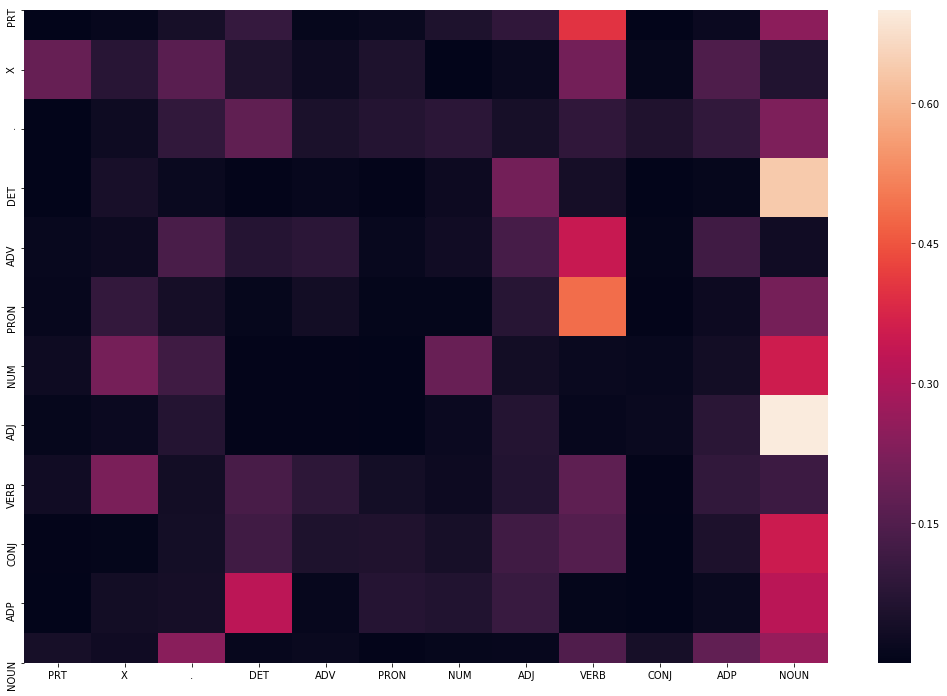

In [23]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

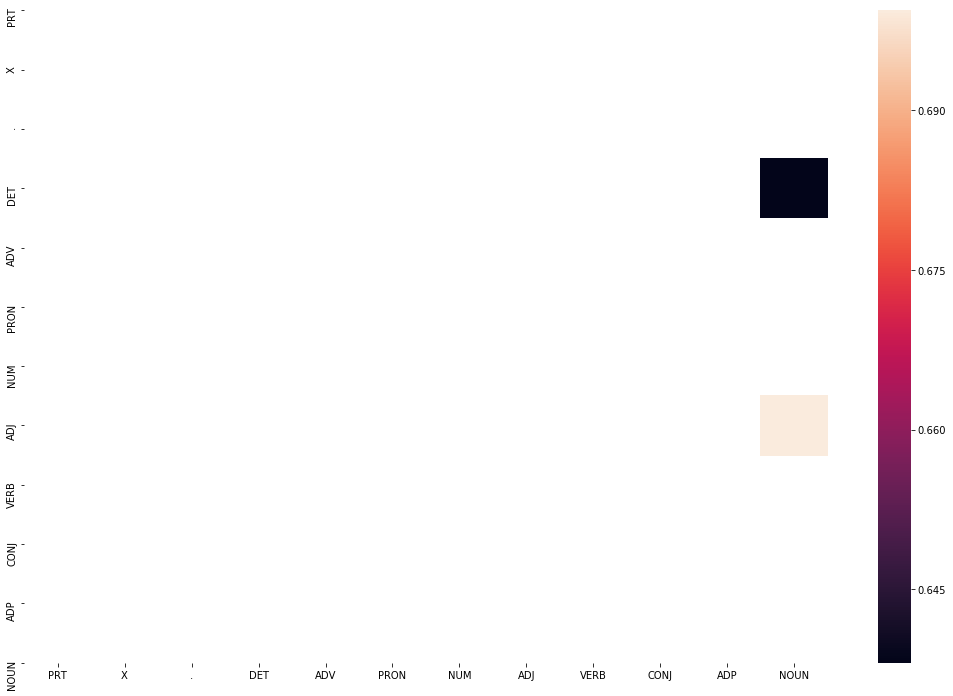

In [24]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [25]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [26]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('Nasty', 'ADJ'),
  ('innuendoes', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*-2', 'X'),
  ('John', 'NOUN'),
  ('Siegal', 'NOUN'),
  (',', '.'),
  ('Mr.', 'NOUN'),
  ('Dinkins', 'NOUN'),
  ("'s", 'PRT'),
  ('issues', 'NOUN'),
  ('director', 'NOUN'),
  (',', '.'),
  ('``', '.'),
  ('designed', 'VERB'),
  ('*', 'X'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('prosecute', 'VERB'),
  ('a', 'DET'),
  ('case', 'NOUN'),
  ('of', 'ADP'),
  ('political', 'ADJ'),
  ('corruption', 'NOUN'),
  ('that', 'DET'),
  ('*T*-74', 'X'),
  ('simply', 'ADV'),
  ('does', 'VERB'),
  ("n't", 'ADV'),
  ('exist', 'VERB'),
  ('.', '.'),
  ("''", '.')],
 [('Mr.', 'NOUN'),
  ('Leinonen', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('expects', 'VERB'),
  ('Ford', 'NOUN'),
  ('to', 'PRT'),
  ('meet', 'VERB'),
  ('the', 'DET'),
  ('deadline', 'NOUN'),
  ('easily', 'ADV'),
  ('.', '.')],
 [('Such', 'DET'),
  ('an', 'DET'),
  ('editorial', 'NOUN'),
  ('point', 'NOUN'),
  

In [27]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [28]:
print("Time taken in seconds: ", difference)

Time taken in seconds:  20.231112003326416


In [29]:
print(tagged_seq)

[('``', '.'), ('Nasty', 'PRT'), ('innuendoes', 'PRT'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*-2', 'X'), ('John', 'NOUN'), ('Siegal', 'PRT'), (',', '.'), ('Mr.', 'NOUN'), ('Dinkins', 'NOUN'), ("'s", 'PRT'), ('issues', 'NOUN'), ('director', 'NOUN'), (',', '.'), ('``', '.'), ('designed', 'VERB'), ('*', 'X'), ('*-1', 'X'), ('to', 'PRT'), ('prosecute', 'PRT'), ('a', 'DET'), ('case', 'NOUN'), ('of', 'ADP'), ('political', 'ADJ'), ('corruption', 'NOUN'), ('that', 'ADP'), ('*T*-74', 'X'), ('simply', 'ADV'), ('does', 'VERB'), ("n't", 'ADV'), ('exist', 'VERB'), ('.', '.'), ("''", '.'), ('Mr.', 'NOUN'), ('Leinonen', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('he', 'PRON'), ('expects', 'VERB'), ('Ford', 'NOUN'), ('to', 'PRT'), ('meet', 'VERB'), ('the', 'DET'), ('deadline', 'NOUN'), ('easily', 'ADV'), ('.', '.'), ('Such', 'ADJ'), ('an', 'DET'), ('editorial', 'NOUN'), ('point', 'NOUN'), ('of', 'ADP'), ('view', 'NOUN'), ('perpetuates', 'PRT'), ('an', 'DET'), ('insidious', 'PRT'), (',', '.'), ('st

In [30]:
# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.8956521739130435


The accuracy of the Vanilla Viterbi Model is `88.88%`

Now, we compare the accuracy with the test sample sentences, provided as part of the assignment

#### Load the Sample Test Sentences File

In [31]:
# Assign the path of the local dir to a variable. 
#This path must be updated, if the notebook is being executed on a different machine.

Local_Dir = r"C:\DS_Learning\Data_Science_IITB\NLP\Assignment"

lfile = r"\Sample_Test_Sentences.txt"

Sample_Sentences = str(Local_Dir + lfile)


In [32]:
#Read the sample sentences
sent =[]
corpus = open(Sample_Sentences, "r")
for item in corpus:
    print(item)
    sent.append(item)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

### Solve the problem of unknown words

In [33]:
print(sent)

['Android is a mobile operating system developed by Google.\n', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n', 'Show me the cheapest round trips from Dallas to Atlanta\n', 'I would like to see flights from Denver to Philadelphia.\n', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n', 'NASA invited social media users to

In [34]:
#Remove the special characters and empty strings from the corpus 
sample_test_corpus =[line.rstrip() for line in sent if line.rstrip()!='']
sample_test_corpus

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [35]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [36]:
incorrect_tagged_cases

[[('``', '.'), (('Nasty', 'PRT'), ('Nasty', 'ADJ'))],
 [('Nasty', 'ADJ'), (('innuendoes', 'PRT'), ('innuendoes', 'NOUN'))],
 [('John', 'NOUN'), (('Siegal', 'PRT'), ('Siegal', 'NOUN'))],
 [('to', 'PRT'), (('prosecute', 'PRT'), ('prosecute', 'VERB'))],
 [('corruption', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('.', '.'), (('Such', 'ADJ'), ('Such', 'DET'))],
 [('view', 'NOUN'), (('perpetuates', 'PRT'), ('perpetuates', 'VERB'))],
 [('an', 'DET'), (('insidious', 'PRT'), ('insidious', 'ADJ'))],
 [(',', '.'), (('stereotyped', 'PRT'), ('stereotyped', 'ADJ'))],
 [('stereotyped', 'ADJ'), (('perspective', 'PRT'), ('perspective', 'NOUN'))],
 [('Michael', 'NOUN'), (('Farren', 'PRT'), ('Farren', 'NOUN'))],
 [('to', 'PRT'), (('rebound', 'NOUN'), ('rebound', 'VERB'))]]

#### It seems, almost all the the words, that are not present in training set are assigned the first pos tag

#### Let's analyse the Sample Test now

In [37]:
#Predictions on the Sample Test Sentences
sample_test_pred =[]
for item in sample_test_corpus:
    sample_test_pred = sample_test_pred + list(Viterbi(word_tokenize(item)))

In [38]:
sample_test_pred

[('Android', 'PRT'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRT'),
 ('.', '.'),
 ('Android', 'PRT'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRT'),
 ('worldwide', 'PRT'),
 ('on', 'ADP'),
 ('smartphones', 'PRT'),
 ('since', 'ADP'),
 ('2011', 'PRT'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'PRT'),
 ('.', '.'),
 ('Google', 'PRT'),
 ('and', 'CONJ'),
 ('Twitter', 'PRT'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRT'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'PRT'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRT'),
 ("'s", 'VERB'),
 ('firehose', 'PRT'),
 ('.', '.'),
 ('Twitter', 'PRT'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRT'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NO

#### The first tag in the training tagset is given for the words such as `mobile`, `Android`, `operating` etc 
#### Let's verify if these words are present in the training corpus

In [39]:
#Get the tokens from the sample test sentences
sample_corpus_token = [tokens for item in sample_test_corpus for tokens in word_tokenize(item)]

In [40]:
#Get the list of tokens that are present in sample test corpus but not in the training corpus
tokens_notin_train_corpus = list(set(sample_corpus_token) - set(tokens))

In [41]:
tokens_notin_train_corpus

['domineering',
 'invited',
 'FIFA',
 'messages',
 'trips',
 'Twitter',
 'Cup',
 'Android',
 '2013',
 'worldwide',
 'smartphones',
 'contested',
 'tweets',
 'firehose',
 'Trump',
 'Satellite',
 'arriving',
 'NASA',
 'online',
 'interact',
 '2011',
 '21st',
 '2018',
 'personality',
 'Google',
 'ICESAT-2',
 'tournament',
 'OS',
 '2015']

#### From the above output, it is evident that the words like `Google`, `Twitter`, `domineering` etc are not present in the training corpus and therefore a default tag has been assigned to these words.

In [42]:
#Let's get the  tags predicted for all the unknown words
[tup for tup in sample_test_pred for token in tokens_notin_train_corpus if tup[0]== token ]

[('Android', 'PRT'),
 ('Google', 'PRT'),
 ('Android', 'PRT'),
 ('OS', 'PRT'),
 ('worldwide', 'PRT'),
 ('smartphones', 'PRT'),
 ('2011', 'PRT'),
 ('2013', 'PRT'),
 ('Google', 'PRT'),
 ('Twitter', 'PRT'),
 ('2015', 'PRT'),
 ('Google', 'PRT'),
 ('Twitter', 'PRT'),
 ('firehose', 'PRT'),
 ('Twitter', 'PRT'),
 ('online', 'PRT'),
 ('interact', 'PRT'),
 ('messages', 'PRT'),
 ('tweets', 'PRT'),
 ('Trump', 'PRT'),
 ('domineering', 'PRT'),
 ('personality', 'PRT'),
 ('2018', 'PRT'),
 ('FIFA', 'PRT'),
 ('Cup', 'PRT'),
 ('21st', 'PRT'),
 ('FIFA', 'PRT'),
 ('Cup', 'PRT'),
 ('tournament', 'PRT'),
 ('contested', 'PRT'),
 ('Cup', 'PRT'),
 ('trips', 'PRT'),
 ('arriving', 'PRT'),
 ('NASA', 'PRT'),
 ('invited', 'PRT'),
 ('ICESAT-2', 'PRT'),
 ('Satellite', 'PRT')]

### EDA On The Training Corpus

In [43]:
#Let's get the  count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'VERB': 12901,
         'PRT': 3045,
         'NOUN': 27428,
         '.': 11140,
         'ADV': 3029,
         'DET': 8276,
         'ADJ': 6077,
         'ADP': 9381,
         'X': 6287,
         'CONJ': 2156,
         'PRON': 2615,
         'NUM': 3359})

In [44]:
# the most common tags can be seen using the most_common() method of Counter
tag_counts.most_common(5)

[('NOUN', 27428), ('VERB', 12901), ('.', 11140), ('ADP', 9381), ('DET', 8276)]

In [45]:
#Let's check the count of incorrectly classified words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'PRT': 9, 'ADP': 1, 'ADJ': 1, 'NOUN': 1})

In [46]:
train_tagged_words

[('According', 'VERB'),
 ('to', 'PRT'),
 ('Dr.', 'NOUN'),
 ('Wright', 'NOUN'),
 (',', '.'),
 ('homelessness', 'NOUN'),
 ('is', 'VERB'),
 ('``', '.'),
 ('simultaneously', 'ADV'),
 ('a', 'DET'),
 ('housing', 'NOUN'),
 ('problem', 'NOUN'),
 (',', '.'),
 ('an', 'DET'),
 ('employment', 'NOUN'),
 ('problem', 'NOUN'),
 (',', '.'),
 ('a', 'DET'),
 ('demographic', 'ADJ'),
 ('problem', 'NOUN'),
 (',', '.'),
 ('a', 'DET'),
 ('problem', 'NOUN'),
 ('of', 'ADP'),
 ('social', 'ADJ'),
 ('disaffiliation', 'NOUN'),
 (',', '.'),
 ('a', 'DET'),
 ('mental', 'ADJ'),
 ('health', 'NOUN'),
 ('problem', 'NOUN'),
 (',', '.'),
 ('a', 'DET'),
 ('family', 'NOUN'),
 ('violence', 'NOUN'),
 ('problem', 'NOUN'),
 (',', '.'),
 ('a', 'DET'),
 ('problem', 'NOUN'),
 ('created', 'VERB'),
 ('*', 'X'),
 ('by', 'ADP'),
 ('the', 'DET'),
 ('cutbacks', 'NOUN'),
 ('in', 'ADP'),
 ('social', 'ADJ'),
 ('welfare', 'NOUN'),
 ('spending', 'NOUN'),
 (',', '.'),
 ('a', 'DET'),
 ('problem', 'NOUN'),
 ('resulting', 'VERB'),
 ('from', 'ADP')

In [47]:
# Let's check the verbs classifed as 'verb ending with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]== 'VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20750329431826992


[('created', 'VERB'),
 ('connected', 'VERB'),
 ('auctioned', 'VERB'),
 ('declined', 'VERB'),
 ('added', 'VERB'),
 ('designed', 'VERB'),
 ('pursued', 'VERB'),
 ('raised', 'VERB'),
 ('answered', 'VERB'),
 ('introduced', 'VERB'),
 ('operated', 'VERB'),
 ('narrowed', 'VERB'),
 ('traded', 'VERB'),
 ('traded', 'VERB'),
 ('traded', 'VERB'),
 ('based', 'VERB'),
 ('selected', 'VERB'),
 ('announced', 'VERB'),
 ('added', 'VERB'),
 ('closed', 'VERB')]

#### More than `20%` of words are tagged as VERB, that should have been tagged as VBD

In [48]:
# Let's check the verbs classifed as 'verb ending with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]== 'VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.10882877296333618


[('According', 'VERB'),
 ('resulting', 'VERB'),
 ('living', 'VERB'),
 ('reaching', 'VERB'),
 ('being', 'VERB'),
 ('preventing', 'VERB'),
 ('lowering', 'VERB'),
 ('soliciting', 'VERB'),
 ('holding', 'VERB'),
 ('following', 'VERB'),
 ('pumping', 'VERB'),
 ('coming', 'VERB'),
 ('admitting', 'VERB'),
 ('denying', 'VERB'),
 ('bring', 'VERB'),
 ('trying', 'VERB'),
 ('bundling', 'VERB'),
 ('targeting', 'VERB'),
 ('losing', 'VERB'),
 ('saying', 'VERB')]

#### More than `10%` of words are tagged as VERB, that should have been tagged as VBG

In [49]:
# Let's see what fraction of adjectives JJ are followed by a noun NN

# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of JJ tags
ADj_tags = [t for t in tags if t == 'ADJ']

# create a list of (JJ, NN) tags
ADJ_NOUN_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(ADj_tags))
print(len(ADJ_NOUN_tags))
print(len(ADJ_NOUN_tags) / len(ADj_tags))

6077
4250
0.6993582359716966


#### More than `70%` of ADJ are followed by NOUN

In [50]:
# Let's  check what fraction of determiners DT are followed by a noun NN
DET_tags = [t for t in tags if t == 'DET']
DET_NOUN_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(DET_tags))
print(len(DET_NOUN_tags))
print(len(DET_NOUN_tags) / len(DET_tags))

8276
5281
0.6381101981633639


#### More than `63%` of DET are followed by NOUN

In [51]:
# Let's check what fraction of adverbs are followed by a verb?
ADV_tags = [t for t in tags if t == 'ADV']
ADV_VERB_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(ADV_tags))
print(len(ADV_VERB_tags))
print(len(ADV_VERB_tags) / len(ADV_tags))

3029
1042
0.34400792340706504


#### Approximately `35%` of Adverbs are followed by Verbs

### Lexicon Based POS Tagging

In [52]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.900040144520273

#### Even a simple unigram tagger seems to perform fairly well with `89.47%` accuracy

In [53]:
# Bigram tagger)
bigram_tagger = nltk.BigramTagger(train_set)
bigram_tagger.evaluate(test_set)

0.2081493376154155

#### With Bigram tagger, the accuracy is very low with `18.41%`

### Rule-Based (Regular Expression) Tagger Using The EDA Perfomed Earlier

In [54]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [55]:
regexp_tagger = nltk.RegexpTagger(patterns)

In [56]:
regexp_tagger.evaluate(test_set)

0.4120835006021678

#### Rule Based tagger is giving a low accuracy  of `41.35%` accuracy

### Combining Tagger

In [57]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

# Bigram backed up by the lexicon tagger
bigram_tagger = nltk.UnigramTagger(train_set, backoff=lexicon_tagger)

bigram_tagger.evaluate(test_set)

0.948815736651947

#### The accuracy is around 94% for a bigram tagger, backed up by, unigram lexicon tagger, which is backed up by a rule based tagger.

### Modified Viterbi Algorithm # 1

We know, if a word is unknown word, then the state probabilities for that word becomes zero and hence the Viterbi algorithm assigned the POS tag to that word, by default with the first tag in the training set.

Therefore, lets modify the Viterbi Algorithm such that when the state probabilities become zero it updates the tag based on the transition probability.

In [58]:
# Viterbi Heuristic
def Viterbi_modified1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        ltrans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            ltrans.append(transition_p)
            
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            state_probability = emission_p * transition_p
            p.append(state_probability)
            
        pmax = max(p)
        
        #Check if the state probability is zero
        if pmax == 0:
            #If state probability is zero, update the tag with the maximum transition probability
            state_max = T[ltrans.index(max(ltrans))]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
        
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [59]:
# Tag the Sample Test Sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_modified1(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

19.902929067611694


In [60]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9391304347826087

#### The accuracy is increased to `93.91%` using the updated Viterbi Algorithm

### Modified Viterbi Algorithm # 2(Laplace Smoothing)

Lets modify the Viterbi Algorithm by adding a very low epsilon value `0.001` to the emission probability to make sure the emission probability never goes to 0.

In [61]:
# Viterbi Heuristic
def Viterbi_modified2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    ep_value = 0.001
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        ltrans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            ltrans.append(transition_p)
            
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            state_probability = (emission_p + ep_value) * transition_p
            p.append(state_probability)
            
        pmax = max(p)
        
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
        
    return list(zip(words, state))

In [62]:
# Tag the Sample Test Sentences with the second updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_modified2(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

20.214087963104248


In [63]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.8347826086956521

#### The accuracy of the updated Viterbi algorithm slightly increased to `83.47%` as compared to Vanilla Viterbi Model 

### Modified Viterbi Algorithm # 3(Combining Taggger)

Modify the Viterbi Algorithm such that when the state probabilities become zero it updates the tag based on the Combining (Bigram => Unigram => Rule Based)Tagger.

In [64]:
# Viterbi Heuristic
def Viterbi_modified3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        ltrans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            ltrans.append(transition_p)
            
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            state_probability = emission_p * transition_p
            p.append(state_probability)
            
        pmax = max(p)
        
        #Check if the state probability is zero
        if pmax == 0:
            #If state probability is zero, update the tag with the maximum transition probability
            state_max = bigram_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
        
    return list(zip(words, state))

In [65]:
# Tag the Sample Test Sentences with the second updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_modified3(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

21.111695528030396


In [66]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9304347826086956

#### With the Combining Tagger, we have achieved the maximum accuracy of `93.04%` out of the 3 models

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [67]:
#Print the Sample Test Sentences with the vanilla Viterbi algorithm
for token in sample_test_corpus:
    print(list(Viterbi(word_tokenize(token))))

[('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.')]
[('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRT'), ('.', '.')]
[('Google', 'PRT'), ('and', 'CONJ'), ('Twitter', 'PRT'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRT'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'PRT'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRT'), ("'s", 'VERB'), ('firehose', 'PRT'), ('.', '.')]
[('Twitter', 'PRT'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRT'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 

In [68]:
#Print the Sample Test Sentences with the modified Viterbi(with combining tagger) algorithm
for token in sample_test_corpus:
    print(list(Viterbi_modified1(word_tokenize(token))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('u

In [69]:
#Print the Sample Test Sentences with the modified Viterbi algorithm
for token in sample_test_corpus:
    print(list(Viterbi_modified3(word_tokenize(token))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

#### The Combining Tagger Version of modidied Viterbi Algorithm has corrected the following sentences with appropriate POS tagging:

***Android is a mobile operating system developed by Google***

Words such as `Android` and `Google` are unknown words and are incorrectly tagged in the vanilla viterbi algorithm. 
These are now correctly classified as Nouns

***Twitter is an online news and social networking service on which users post and interact with messages known as tweets***

In this sentence, words such as `Twitter` and `tweets` are unknown words and are incorrectly tagged in the vanilla viterbi algorithm. These are correctly now classified as Nouns

***Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.***

In this sentence, words such as `Android`, `worldwide` are unknown words and are incorrectly tagged in the vanilla viterbi algorithm. These are correctly now classified as Nouns

In addition, `2011`, `2013` are incorrectly classified by vanilla algorith, but in the updated version there is a rule for indicating cardinal numbers, therefore `2011` is correctly tagged as 'NUM'.

***NASA invited social media users to experience the launch of ICESAT-2 Satellite.***

In this sentence, words such as `NASA` and `ICESAT-2` are unknown words and are incorrectly tagged in the vanilla viterbi algorithm. These are correctly now classified as Nouns